Lets verify data split

In [54]:
from vpr_model import VPRModel
from dataloaders.MapsDataloader import MapsDataModule

import pandas as pd
import os
from PIL import Image
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
from pandas import DataFrame
import datetime
from matplotlib import pyplot as plt

import utm
import cv2
from typing import List, Dict, Tuple, Optional

In [55]:

visloc_satelite_shandan_output_csv = '/workspace/repos/drone-loc-no-gps/Dataframes/Shandan.csv'
visloc_satelite_shandan_output_csv_an = '/workspace/repos/drone-loc-no-gps/Dataframes/Shandan_out.csv'
visloc_taizhou = '/home/user/PycharmProjects/mgr-repack/Dataframes/Taizhou-1.csv'
visloc_taizhou_out = '/home/user/PycharmProjects/mgr-repack/Dataframes/Taizhou-1_out.csv'
# df = pd.read_csv(visloc_satelite_shandan_output_csv)

In [56]:
# def get_utm(row):
#     e, n, zone_num, zone_let = utm.from_latlon(row.lat, row.lon)
#     zone = f'{zone_num}{zone_let or ""}'

#     return {'e_utm': e, 'n_utm': n, 'zone_utm': zone}

In [57]:
# df = df.join(df.apply(get_utm, axis=1).apply(pd.Series))

In [58]:
# APPLY IS NOT REQUIRED
# df.to_csv(visloc_satelite_shandan_output_csv_an, index=True)
df = pd.read_csv(visloc_satelite_shandan_output_csv)

In [59]:
satellite_records = df[df['friendly-name'].str.contains('satellite')]
# satellite_records = df[~df['friendly-name'].str.contains('uav')]
uav_records = df[df['friendly-name'].str.contains('uav')]

In [60]:
common_place_ids = set(satellite_records['place_id']).intersection(set(uav_records['place_id']))
if not common_place_ids:
    print("The same place_id for satellite and uav not found")

In [69]:
first_common_place_id = sorted(common_place_ids)[3]
print(first_common_place_id)

5


In [70]:
satellite_series = satellite_records[satellite_records['place_id'] == first_common_place_id]
uav_series = uav_records[uav_records['place_id'] == first_common_place_id]

In [71]:
def get_neigbourhood(series, df: DataFrame, range: int = 300):
    if isinstance(series, pd.DataFrame):
        if len(series) == 0:
            return pd.DataFrame()
        series = series.iloc[0]
    
    e_center = series['e_utm']
    n_center = series['n_utm'] 
    zone = series['zone_utm']
    
    neighbours = df[(
        df['e_utm'].between(e_center-range, e_center+range) &
        df['n_utm'].between(n_center-range, n_center+range) &
        (df['zone_utm'] == zone)
        )]
    return neighbours

In [72]:
satellite_related = get_neigbourhood(satellite_series, satellite_records)
print(len(satellite_related))
uav_related = get_neigbourhood(uav_series, uav_records)
print(len(uav_related))



6
5


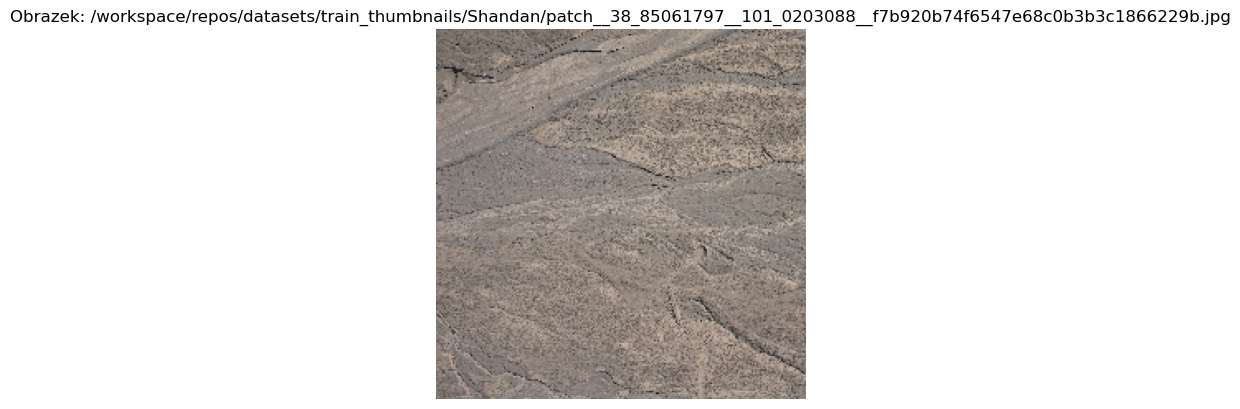

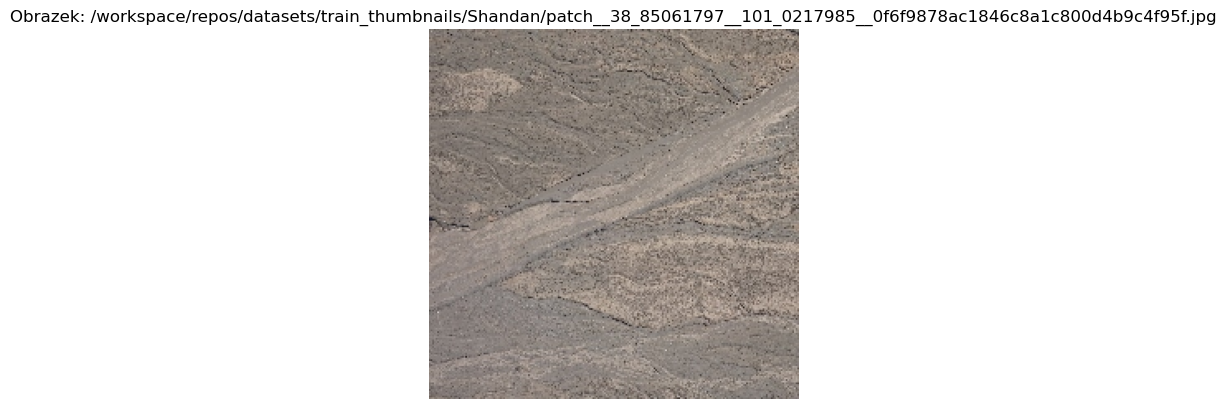

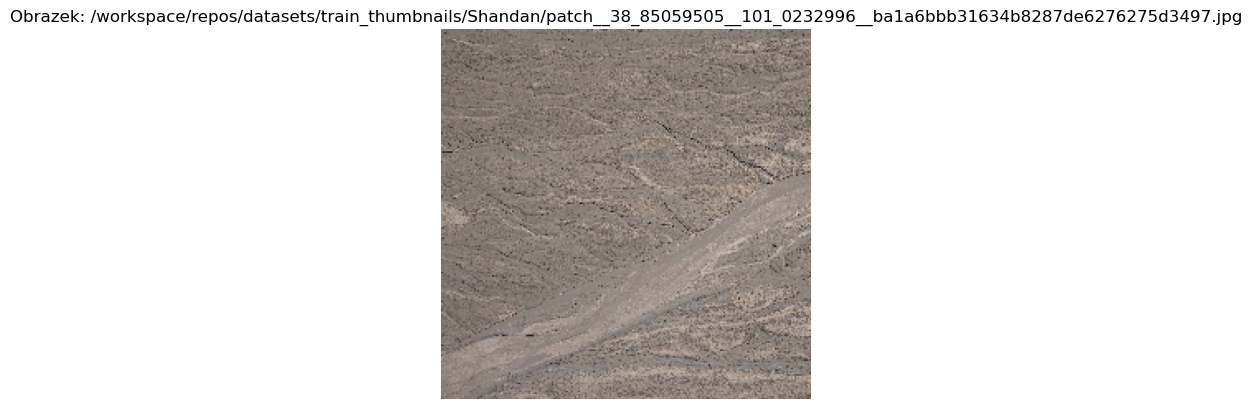

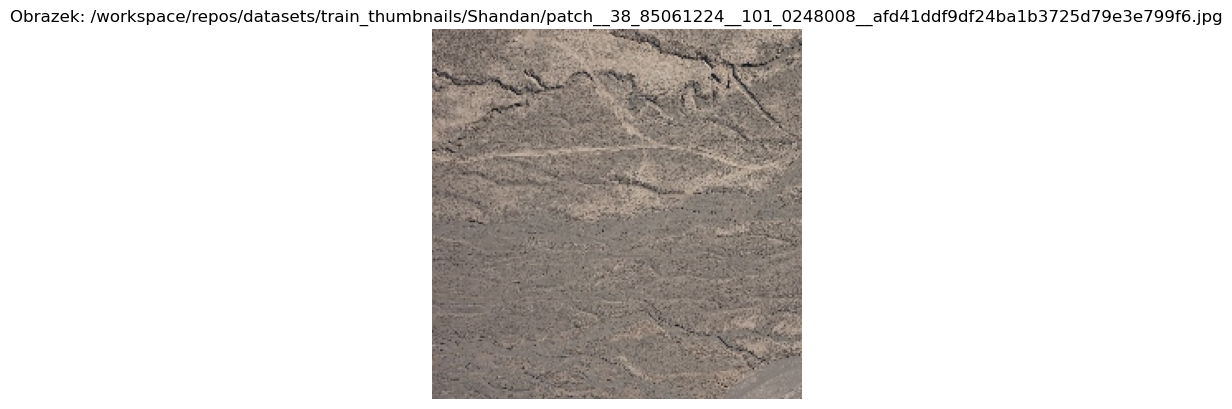

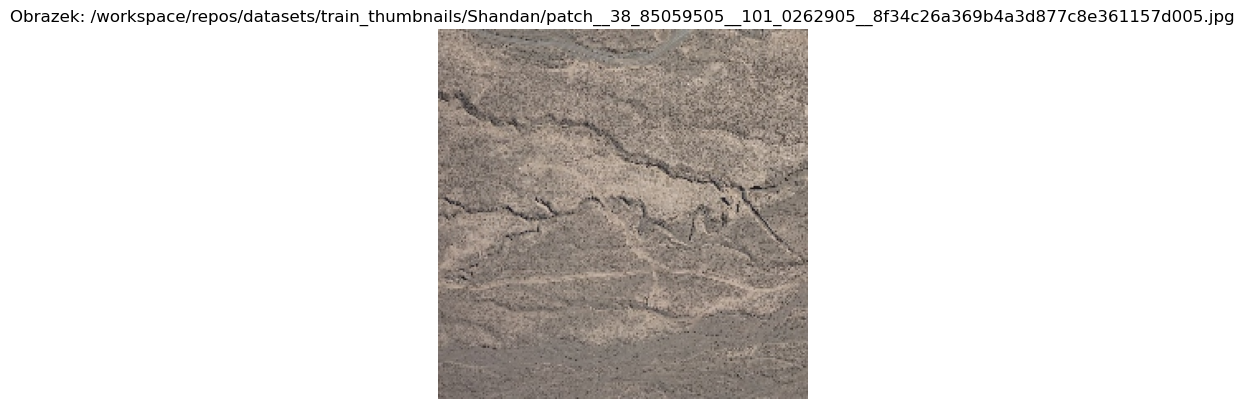

In [73]:
for img_path in uav_related['img_path']:
    # 2. Wczytujemy obrazek
    # str() jest tutaj dobrym zabezpieczeniem, jeśli ścieżki nie są stringami
    img = cv2.imread(str(img_path)) 
    
    # 3. BARDZO WAŻNE: Sprawdzamy, czy obrazek został poprawnie wczytany
    if img is None:
        print(f"Błąd: Nie udało się wczytać obrazka ze ścieżki: {img_path}")
        continue # Przechodzimy do następnej iteracji pętli

    # 4. BARDZO WAŻNE: Konwersja kolorów z BGR (OpenCV) na RGB (Matplotlib)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 5. Wyświetlamy obrazek z dodatkowymi informacjami
    plt.imshow(img_rgb)
    plt.title(f"Obrazek: {img_path}") # Dodajemy tytuł dla kontekstu
    plt.axis('off') # Wyłączamy osie dla lepszej prezentacji
    plt.show()

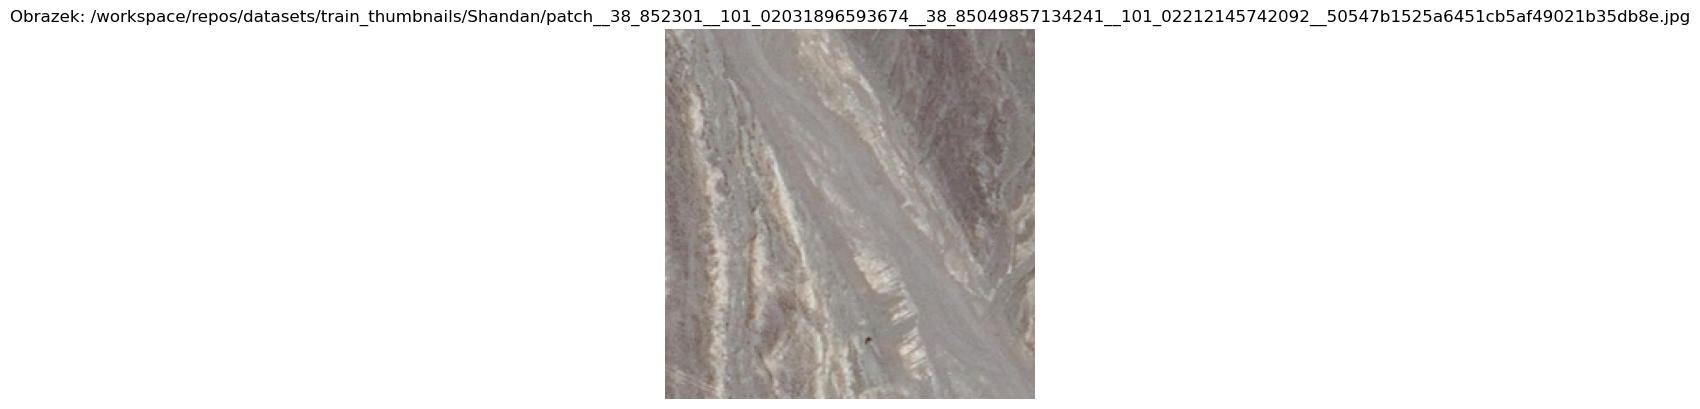

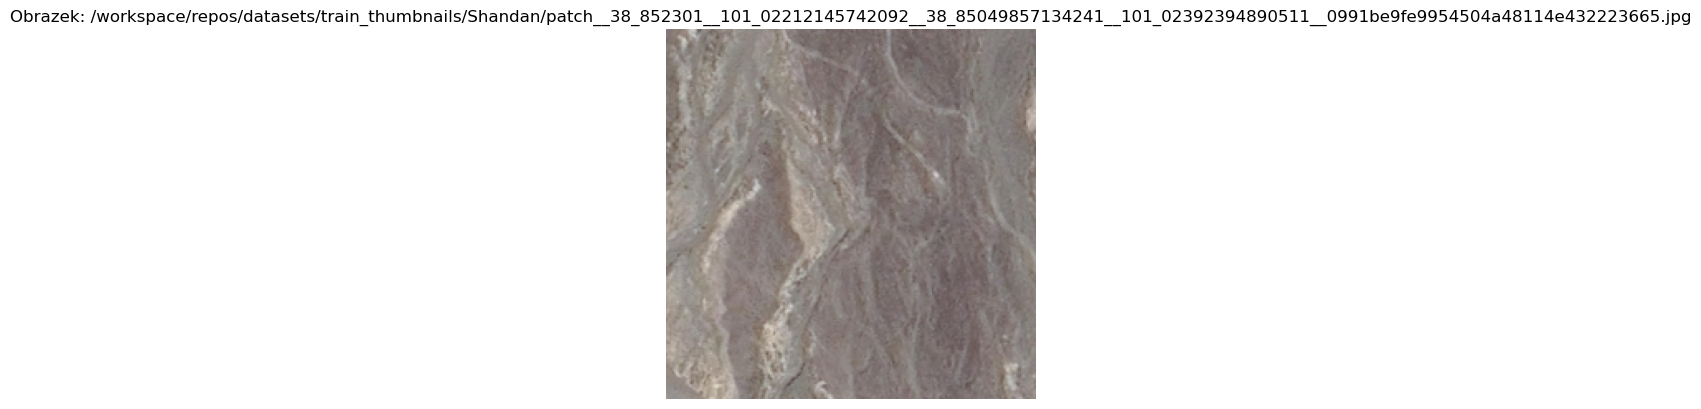

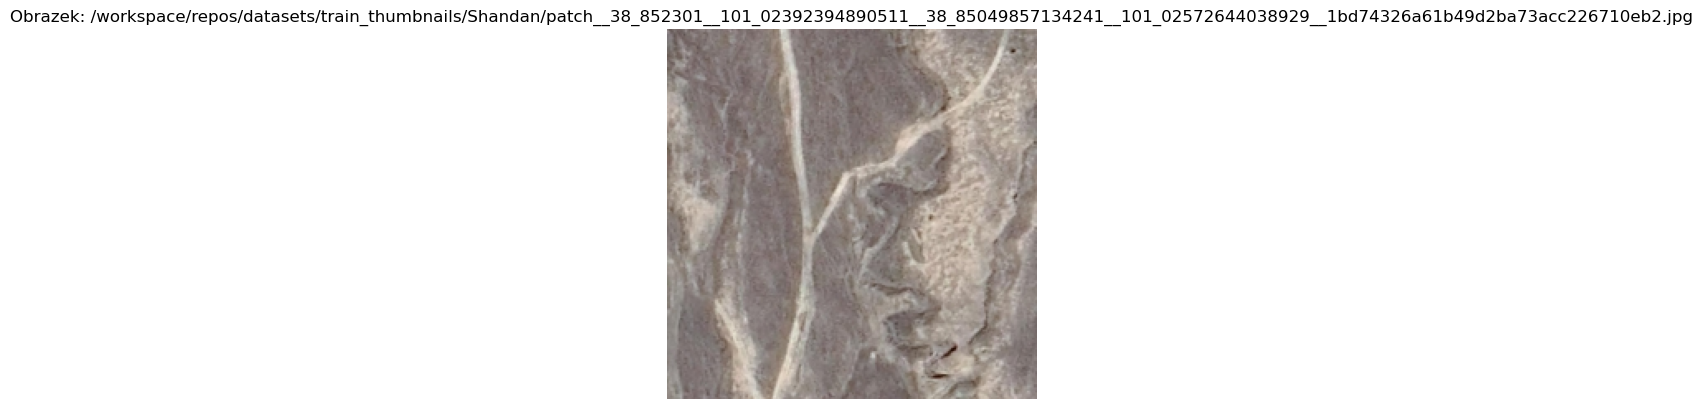

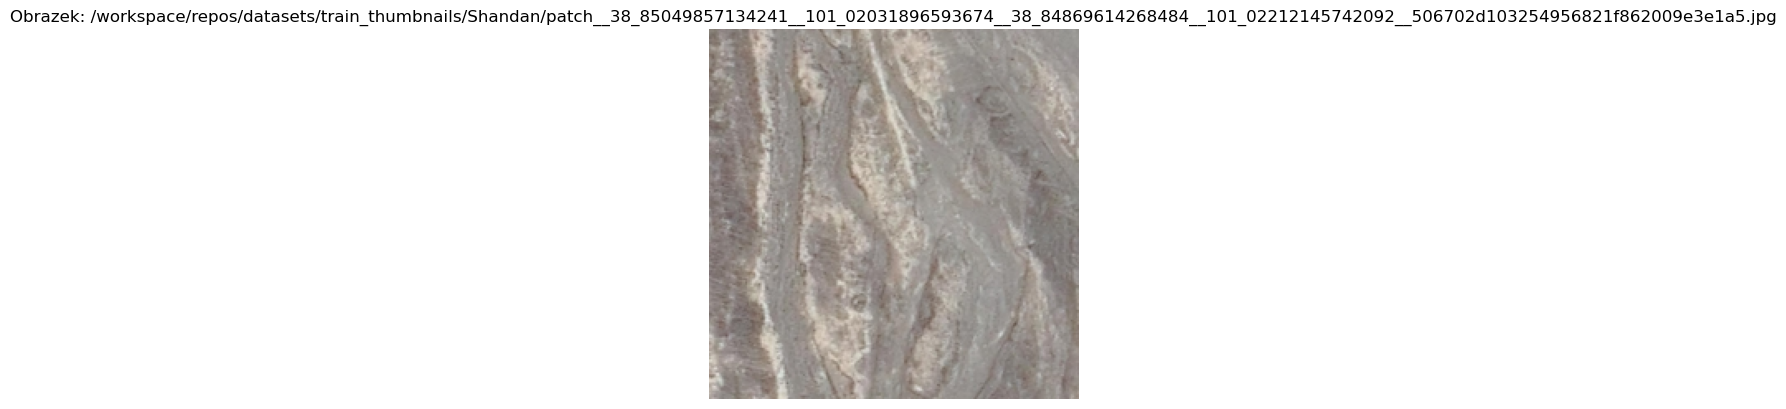

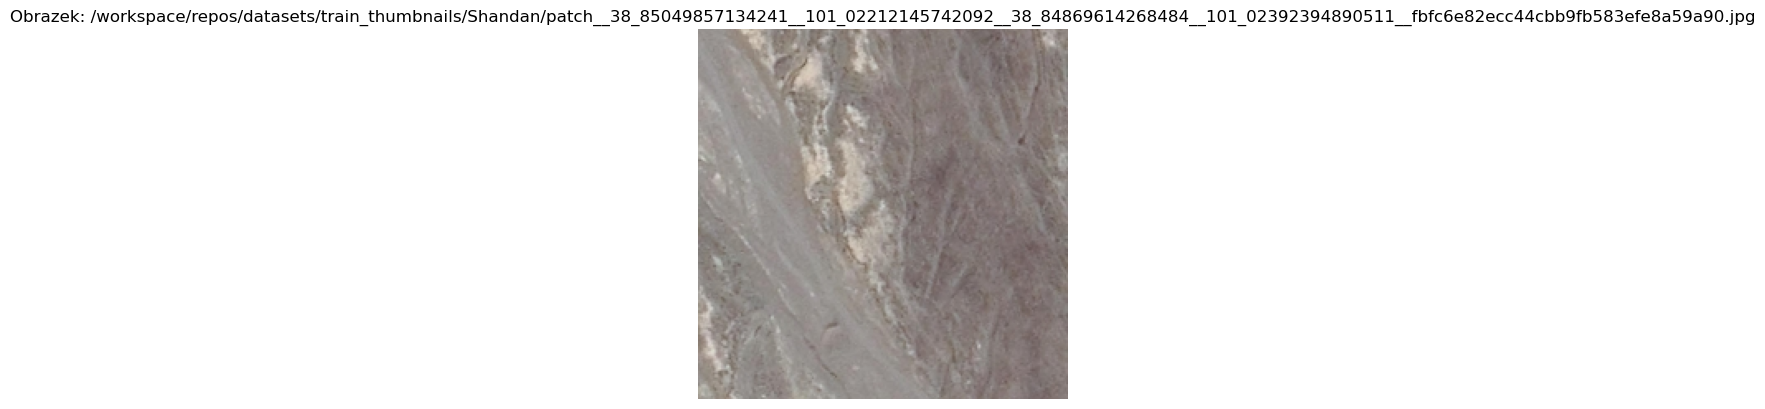

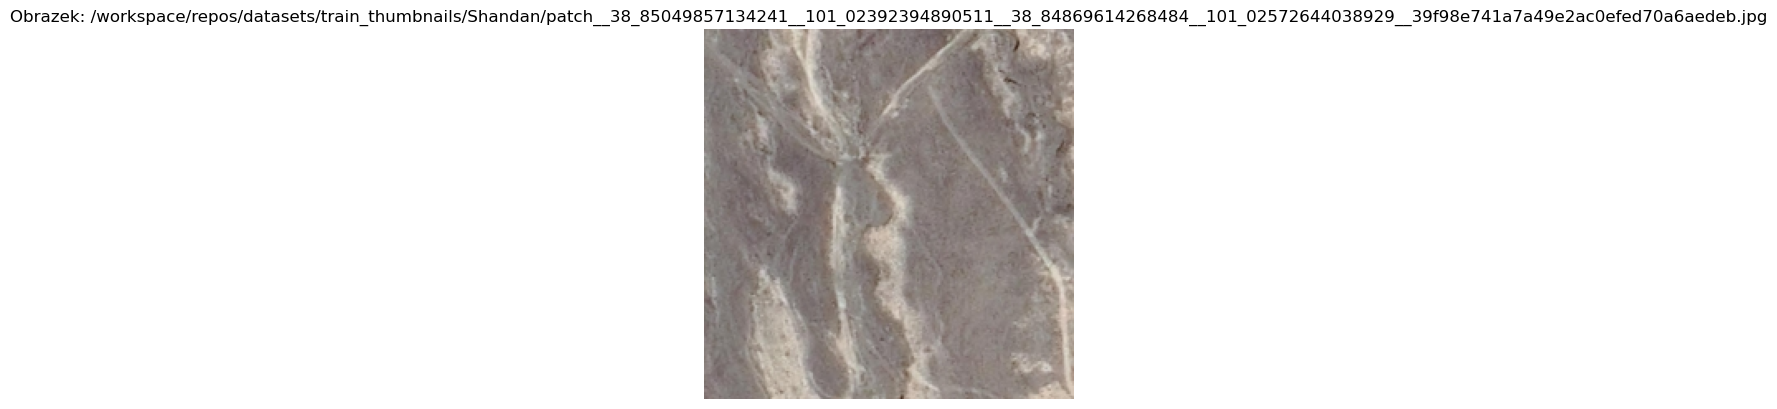

In [74]:
for img_path in satellite_related['img_path']:
    # 2. Wczytujemy obrazek
    # str() jest tutaj dobrym zabezpieczeniem, jeśli ścieżki nie są stringami
    img = cv2.imread(str(img_path)) 
    
    # 3. BARDZO WAŻNE: Sprawdzamy, czy obrazek został poprawnie wczytany
    if img is None:
        print(f"Błąd: Nie udało się wczytać obrazka ze ścieżki: {img_path}")
        continue # Przechodzimy do następnej iteracji pętli

    # 4. BARDZO WAŻNE: Konwersja kolorów z BGR (OpenCV) na RGB (Matplotlib)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 5. Wyświetlamy obrazek z dodatkowymi informacjami
    plt.imshow(img_rgb)
    plt.title(f"Obrazek: {img_path}") # Dodajemy tytuł dla kontekstu
    plt.axis('off') # Wyłączamy osie dla lepszej prezentacji
    plt.show()

In [19]:
import cv2
import numpy as np
import pandas as pd
from typing import Dict, Tuple, Optional

# --------- helpers ---------

def _ensure_series(s):
    if isinstance(s, pd.DataFrame):
        if len(s) == 0:
            raise ValueError("Empty DataFrame passed as center")
        return s.iloc[0]
    if isinstance(s, pd.Series):
        return s
    raise TypeError("center_series must be a pandas Series or 1-row DataFrame")

def _robust_step_from_center_deltas(deltas: np.ndarray) -> Optional[float]:
    """
    Szacuje krok z |delta| względem środka, odporne na szum:
    - bierze tryb histogramu (FD bins),
    - rozważa kilka kandydatów (mode, median z najmniejszych, połowy),
    - wybiera kandydata o najniższym medianowym błędzie frakcyjnym.
    """
    v = np.abs(deltas[np.isfinite(deltas)])
    v = v[v > 1e-6]
    if v.size == 0:
        return None

    # 1) tryb histogramu (Freedman–Diaconis)
    try:
        counts, edges = np.histogram(v, bins='fd')
        if counts.size == 0:
            mode1 = None
        else:
            mx = counts.max()
            # bierzemy najwcześniejszy bin z maksymalną liczbą trafień (skłonność do mniejszego kroku)
            idx = int(np.flatnonzero(counts == mx)[0])
            mode1 = 0.5 * (edges[idx] + edges[idx + 1])
    except Exception:
        mode1 = None

    # 2) mediana z najmniejszych wartości (ignoruje duże wielokrotności kroku)
    vs = np.sort(v)
    k = min(5, vs.size)
    med_small = float(np.median(vs[:k]))

    # kandydaci
    cands = []
    for c in [mode1, med_small]:
        if c is not None and c > 1e-6:
            cands.append(c)
            if c / 2 > 1e-6:  # jeśli mode wskazał 2*step, to c/2 ≈ step
                cands.append(c / 2)
    # unikalni kandydaci
    cands = sorted({round(float(x), 8) for x in cands if np.isfinite(x)})

    if not cands:
        return None

    # funkcja oceny: jak dobrze v/cand leży na liczbach całkowitych
    def score(c):
        r = np.abs(v / c - np.round(v / c))
        return np.median(r)  # im mniejsza tym lepsza

    scores = [(score(c), c) for c in cands]
    # wybierz o najniższym błędzie; przy remisie weź mniejszą wartość (preferencja 1*step nad 2*step)
    scores.sort(key=lambda t: (t[0], t[1]))
    return float(scores[0][1])

def _infer_steps_from_df(neighbours_df: pd.DataFrame, center: pd.Series,
                         e_col: str, n_col: str) -> Tuple[Optional[float], Optional[float]]:
    e0, n0 = float(center[e_col]), float(center[n_col])
    dE = neighbours_df[e_col].to_numpy(dtype=float) - e0
    dN = neighbours_df[n_col].to_numpy(dtype=float) - n0
    step_e = _robust_step_from_center_deltas(dE)
    step_n = _robust_step_from_center_deltas(dN)
    return step_e, step_n

def _map_axis(delta: float, step: float, tol_ratio: float) -> Tuple[int, float, bool]:
    idx = int(np.round(delta / step))
    target = idx * step
    residual = abs(delta - target)
    tol = step * tol_ratio
    return idx, residual, residual <= tol

def _find_path_col(df: pd.DataFrame, fallback: Optional[str] = None) -> str:
    if fallback and fallback in df.columns:
        return fallback
    for c in ['path', 'filepath', 'image_path', 'img_path', 'file', 'uri']:
        if c in df.columns:
            return c
    raise KeyError("Nie znalazłem kolumny ze ścieżką do obrazu. Podaj path_col explicite.")

def _load_ref_shape(center_series: pd.Series, grid: Dict[Tuple[int, int], pd.Series], path_col: str) -> Tuple[int, int]:
    paths_to_try = []
    if path_col in center_series and pd.notna(center_series[path_col]):
        paths_to_try.append(center_series[path_col])
    for s in grid.values():
        if path_col in s and pd.notna(s[path_col]):
            paths_to_try.append(s[path_col])
    for p in paths_to_try:
        img = cv2.imread(str(p), cv2.IMREAD_COLOR)
        if img is not None:
            h, w = img.shape[:2]
            return h, w
    return 512, 512  # fallback jeśli nic nie da się wczytać

# --------- budowa siatki ---------

def build_grid_auto_from_df(neighbours_df: pd.DataFrame,
                            center_series: pd.Series,
                            e_col: str = 'e_utm',
                            n_col: str = 'n_utm',
                            step_e: Optional[float] = None,
                            step_n: Optional[float] = None,
                            tol_ratio: float = 0.4,      # odrobinę ciaśniej dla większych siatek
                            prefer_col: Optional[str] = None,
                            min_radius: int = 1,
                            max_radius: int = 2,         # max 5x5
                            force_radius: Optional[int] = None
                            ) -> Tuple[Dict[Tuple[int, int], pd.Series], Tuple[Optional[float], Optional[float]], int]:
    """
    Zwraca:
      - grid: {(gi, gj) -> Series}, gi: N(+)/S(-), gj: W(-)/E(+)
      - (step_e, step_n)
      - radius (R)
    """
    center = _ensure_series(center_series)
    e0, n0 = float(center[e_col]), float(center[n_col])

    if step_e is None or step_n is None:
        se, sn = _infer_steps_from_df(neighbours_df, center, e_col, n_col)
        step_e = se if step_e is None else step_e
        step_n = sn if step_n is None else step_n

    if step_e is None or step_n is None or step_e <= 0 or step_n <= 0:
        raise ValueError("Nie udało się wiarygodnie wyestymować step_e/step_n. Podaj je ręcznie (np. GSD*rozmiar_px).")

    grid: Dict[Tuple[int, int], pd.Series] = {}
    costs: Dict[Tuple[int, int], Tuple[float, float]] = {}

    grid[(0, 0)] = center
    costs[(0, 0)] = (0.0, 0.0)

    # Przypisanie kafli do indeksów
    for _, row in neighbours_df.iterrows():
        dE = float(row[e_col]) - e0
        dN = float(row[n_col]) - n0
        if abs(dE) < 1e-6 and abs(dN) < 1e-6:
            continue

        gi, rN, okN = _map_axis(dN, step_n, tol_ratio)  # rząd (N/S)
        gj, rE, okE = _map_axis(dE, step_e, tol_ratio)  # kolumna (W/E)
        if not (okN and okE):
            continue

        # ogranicz promień
        if abs(gi) > max_radius or abs(gj) > max_radius:
            continue

        pos = (gi, gj)
        cost = rN*rN + rE*rE
        prefer_metric = 0.0
        if prefer_col and (prefer_col in row) and pd.notna(row[prefer_col]):
            try:
                prefer_metric = float(row[prefer_col])
            except Exception:
                pass

        if pos not in grid:
            grid[pos] = row
            costs[pos] = (cost, prefer_metric)
        else:
            curr_cost, curr_pref = costs[pos]
            if (cost < curr_cost - 1e-9) or (abs(cost - curr_cost) <= 1e-9 and prefer_metric > curr_pref):
                grid[pos] = row
                costs[pos] = (cost, prefer_metric)

    # Auto-promień z zajętych komórek
    ext = 0
    for (i, j) in grid.keys():
        ext = max(ext, abs(i), abs(j))
    radius = max(min_radius, min(ext, max_radius))

    if force_radius is not None:
        radius = max(min_radius, min(force_radius, max_radius))

    return grid, (step_e, step_n), radius

# --------- mozaika z placeholderami + czerwona ramka w centrum ---------

def concat_grid_with_placeholders_df(grid: Dict[Tuple[int, int], pd.Series],
                                     center_series: pd.Series,
                                     path_col: str = 'path',
                                     radius: int = 1,
                                     fill_color: Tuple[int, int, int] = (0, 0, 0),
                                     draw_center_border: bool = True,
                                     border_color: Tuple[int, int, int] = (0, 0, 255),
                                     border_thickness: int = 10) -> np.ndarray:
    center_series = _ensure_series(center_series)

    any_df = pd.concat(
        [center_series.to_frame().T] + [s.to_frame().T for s in grid.values()],
        ignore_index=True, sort=False
    )
    path_col = _find_path_col(any_df, fallback=path_col)

    ref_h, ref_w = _load_ref_shape(center_series, grid, path_col)
    blank = np.full((ref_h, ref_w, 3), fill_color, dtype=np.uint8)

    def load_resize(path: str) -> np.ndarray:
        img = cv2.imread(str(path), cv2.IMREAD_COLOR)
        if img is None:
            return blank.copy()
        if img.shape[:2] != (ref_h, ref_w):
            img = cv2.resize(img, (ref_w, ref_h), interpolation=cv2.INTER_AREA)
        return img

    def add_border(img: np.ndarray) -> np.ndarray:
        out = img.copy()
        cv2.rectangle(out, (0, 0), (ref_w - 1, ref_h - 1), border_color, border_thickness)
        return out

    list_2d = []
    for gi in range(radius, -radius - 1, -1):       # wiersze: góra (N) -> dół (S)
        row_imgs = []
        for gj in range(-radius, radius + 1):       # kolumny: lewo (W) -> prawo (E)
            row = grid.get((gi, gj))
            if row is None or path_col not in row or pd.isna(row[path_col]):
                tile = blank.copy()
            else:
                tile = load_resize(row[path_col])
            if draw_center_border and gi == 0 and gj == 0:
                tile = add_border(tile)
            row_imgs.append(tile)
        list_2d.append(row_imgs)

    rows = [cv2.hconcat(r) for r in list_2d]
    return cv2.vconcat(rows)

# --------- high-level ---------

def make_mosaic_auto_from_df(neighbours_df: pd.DataFrame,
                             center_series: pd.Series,
                             e_col: str = 'e_utm',
                             n_col: str = 'n_utm',
                             path_col: str = 'path',
                             tol_ratio: float = 0.4,
                             step_e: Optional[float] = None,
                             step_n: Optional[float] = None,
                             fill_color: Tuple[int, int, int] = (0, 0, 0),
                             min_radius: int = 1,         # min 3x3
                             max_radius: int = 2,         # max 5x5
                             force_radius: Optional[int] = None,  # np. 2 żeby wymusić 5x5
                             border_color: Tuple[int, int, int] = (0, 0, 255),
                             border_thickness: int = 10):
    grid, steps, radius = build_grid_auto_from_df(
        neighbours_df, center_series, e_col=e_col, n_col=n_col,
        step_e=step_e, step_n=step_n, tol_ratio=tol_ratio,
        min_radius=min_radius, max_radius=max_radius, force_radius=force_radius
    )
    mosaic = concat_grid_with_placeholders_df(
        grid, center_series, path_col=path_col, radius=radius,
        fill_color=fill_color, draw_center_border=True,
        border_color=border_color, border_thickness=border_thickness
    )
    return mosaic, grid, steps, radius

# Opcja: zawsze 3x3 — brakujące pola wypełnione
def make_mosaic_3x3_strict(neighbours_df: pd.DataFrame,
                           center_series: pd.Series,
                           e_col: str = 'e_utm',
                           n_col: str = 'n_utm',
                           path_col: str = 'path',
                           tol_ratio: float = 0.4,
                           step_e: Optional[float] = None,
                           step_n: Optional[float] = None,
                           fill_color: Tuple[int, int, int] = (0, 0, 0),
                           border_color: Tuple[int, int, int] = (0, 0, 255),
                           border_thickness: int = 10):
    return make_mosaic_auto_from_df(
        neighbours_df, center_series,
        e_col=e_col, n_col=n_col, path_col=path_col,
        tol_ratio=tol_ratio, step_e=step_e, step_n=step_n,
        fill_color=fill_color, min_radius=1, max_radius=1, force_radius=1,
        border_color=border_color, border_thickness=border_thickness
    )

SAT steps: 54.37027129 67.8322679


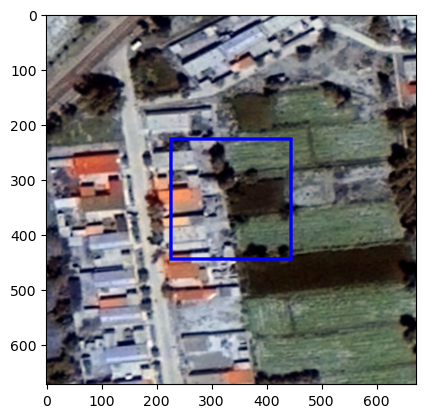

In [20]:
sat_mosaic, sat_grid, (sat_step_e, sat_step_n), sat_R = make_mosaic_3x3_strict(
    satellite_related, satellite_series,
    e_col='e_utm', n_col='n_utm', path_col='path',
    tol_ratio=0.4,   # dla większych siatek możesz spróbować 0.35–0.45
)
# cv2.imwrite('satellite_mosaic.png', sat_mosaic)
print('SAT steps:', sat_step_e, sat_step_n)
plt.imshow(sat_mosaic)
plt.show()


In [21]:
grid, (se, sn), R = build_grid_auto_from_df(
    satellite_related, satellite_series,
    e_col='e_utm', n_col='n_utm',
    tol_ratio=0.5, min_radius=1, max_radius=2
)
print(f"Tiles in grid: {len(grid)} | step_e={se:.3f} | step_n={sn:.3f} | R={R}")

Tiles in grid: 23 | step_e=54.370 | step_n=67.832 | R=2


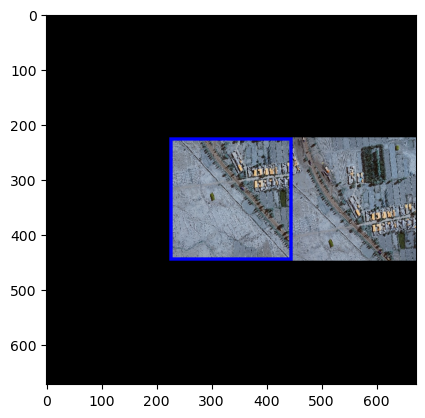

In [23]:
uav_mosaic, uav_grid, (uav_step_e, uav_step_n), uav_R = make_mosaic_3x3_strict(
    uav_related, uav_series, e_col='e_utm', n_col='n_utm', path_col='path', tol_ratio=0.45,
)
# cv2.imwrite('uav_mosaic.png', uav_mosaic)
plt.imshow(uav_mosaic)
plt.show()